# Курсовой проект по теме "Real Estate Price Prediction"
### Daria Rozina

## Задание для курсового проекта

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Сдача проекта:

Рекомендации для файла с кодом (ipynb):

- Файл должен содержать заголовки и комментарии
- Повторяющиеся операции лучше оформлять в виде функций
- По возможности добавлять графики, описывающие данные (около 3-5)
- Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
- Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)

Весь проект должен быть в одном скрипте (файл ipynb).
При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

#### Подключеним библиотеки и скрипты:

In [504]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score


from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14}) #размер шрифта

import warnings #подключение предупреждений
warnings.filterwarnings('ignore')

#### Задаем функцию для подсчета метрик

In [505]:
def r2_metrics(y_tr, y_vl, y_tr_prd, y_vl_prd):
    # Посчитаем коэффициент детерминации R2
    print("R2 TRAIN:\t" + str(r2_score(y_tr, y_tr_prd)))
    print("R2 TEST:\t" + str(r2_score(y_vl, y_vl_prd)))

    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(y_tr_prd, y_tr)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Тренировочные значения')
    plt.title('Тренировочные предсказания')
    
    plt.subplot(122)
    sns.scatterplot(y_vl_prd, y_vl)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Валидационные значения')
    plt.title('Валидационные предсказания')
    plt.show()

### Загрузка данных:

In [506]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#### Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [507]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [508]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [509]:
print(f'Train: {train_df.shape[0]} строк и {train_df.shape[1]} столбцов')
print(f'Test: {test_df.shape[0]} строк и {test_df.shape[1]} столбцов')

Train: 10000 строк и 20 столбцов
Test: 5000 строк и 19 столбцов


### Рассмотрим целевую переменную:

	Mean= 214138.86    Median= 192269.64487934904


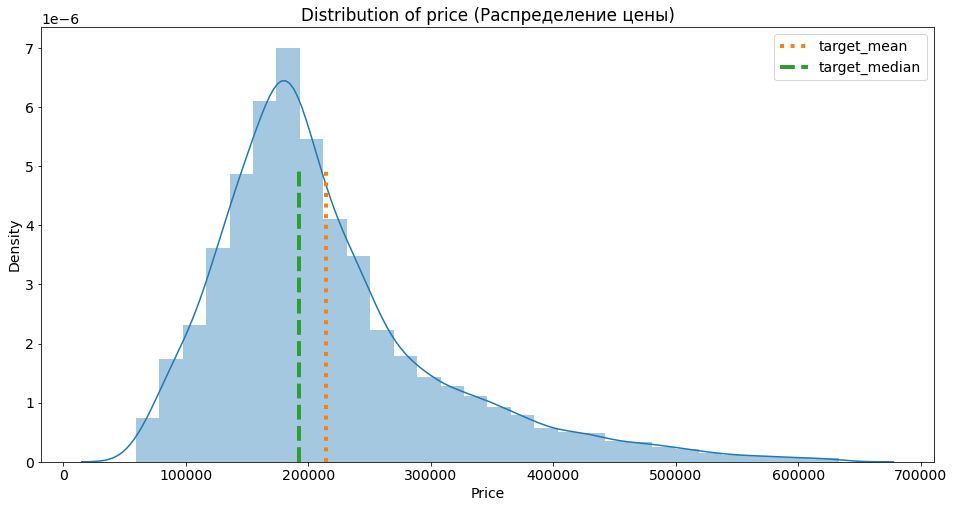

In [510]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=30)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label = 'target_mean', linestyle = ':',  linewidth = 4)
plt.plot([target_median] * 10, y, label = 'target_median', linestyle = '--',  linewidth = 4)

plt.title('Distribution of price (Распределение цены)')
plt.legend()
print (f"\tMean= {target_mean}    Median= {target_median}")

### Проверка на корреляцию признаков:

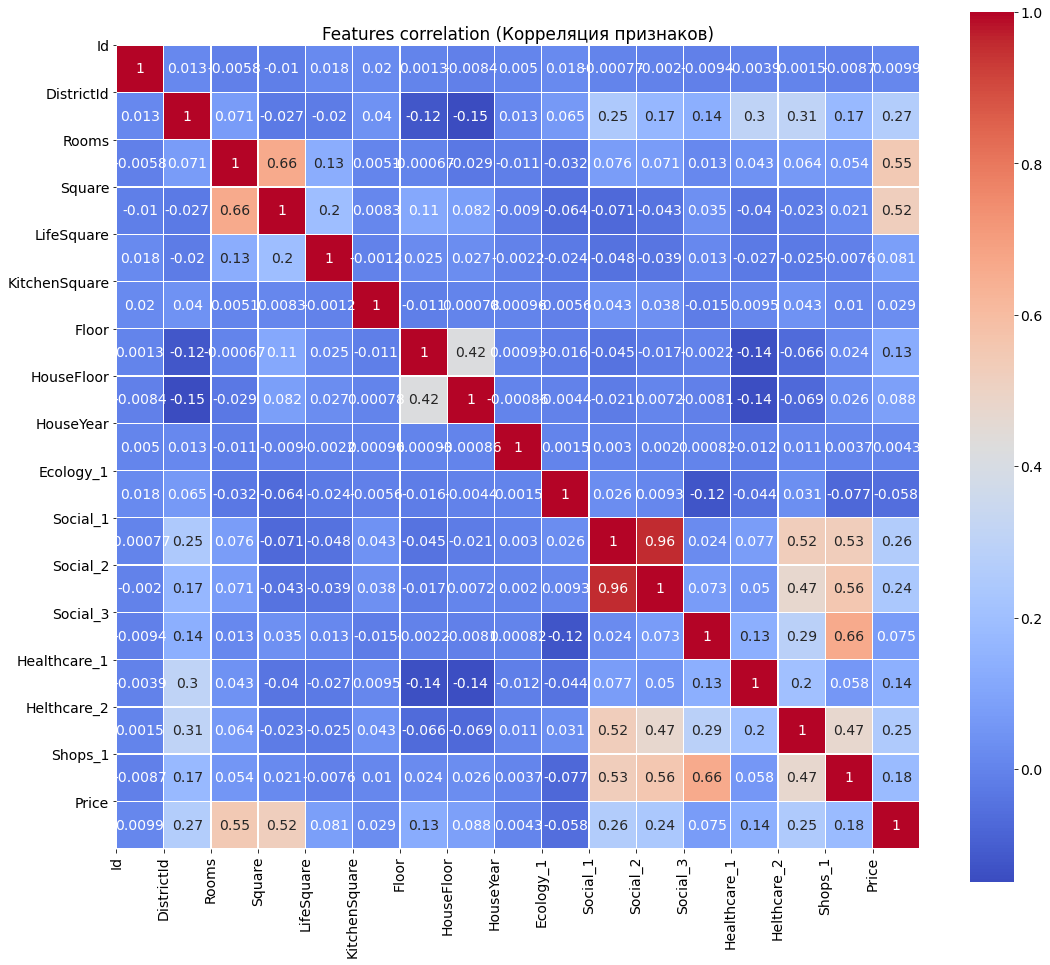

In [511]:
corr = train_df.corr()
fig, ax = plt.subplots(figsize = (18, 16))
sns.heatmap(corr, annot=True, linewidths=0.3, cmap='coolwarm', square=True)
plt.title('Features correlation (Корреляция признаков)')
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

Исходя из таблицы видим, что целевая переменная (цена) сильно зависит от количества комнат и площади

## Анализ данных

### Переводим ID в строковый тип:
    
Эти данные не несут значимой информации. В последующем они могут помешать в построении модели, приведем их к строковому типу данных:

In [512]:
train_df['Id'] = train_df['Id'].astype(str)
train_df.dtypes

Id                object
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Статистика датафрема train:

#### Количественные значения:

In [513]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Информация о пропусках:

In [514]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В признаках **LifeSquare** и **Healthcare_1** есть пропуски (отсутствуют значения).

В признаках **Rooms, KitchenSquare, HouseFloor, Ecology_1, Social_1, Social_3, Heathcare_1, Helthcare_2, Shops_1** есть нулевые значения, возможно это - пропуски.

**LifeSquare, KitchenSquare, HouseFloor, HouseYear, Social_2, Social_3, Shops_1** максимальные значения существенно отличаются, вероятно это - выбросы.

Сортировка признака DistrictId

6668      0
9414      0
166       0
167       0
6292      0
       ... 
261     205
2120    207
4974    208
3048    208
8332    209
Name: DistrictId, Length: 10000, dtype: int64

Сортировка признака Rooms

2194     0.0
6401     0.0
7929     0.0
7644     0.0
3780     0.0
        ... 
1459     5.0
8794     6.0
2728    10.0
2004    10.0
6088    19.0
Name: Rooms, Length: 10000, dtype: float64

Сортировка признака Square

7470      1.136859
4496      1.988943
9869      2.377248
8572      2.596351
161       2.954309
           ...    
7644    212.932361
1906    275.645284
7010    409.425181
726     604.705972
9229    641.065193
Name: Square, Length: 10000, dtype: float64

Сортировка признака LifeSquare

3113    0.370619
1829    0.641822
119     0.795539
9869    0.873147
6882    1.049867
          ...   
9975         NaN
9978         NaN
9981         NaN
9983         NaN
9991         NaN
Name: LifeSquare, Length: 10000, dtype: float64

Сортировка признака Kitch

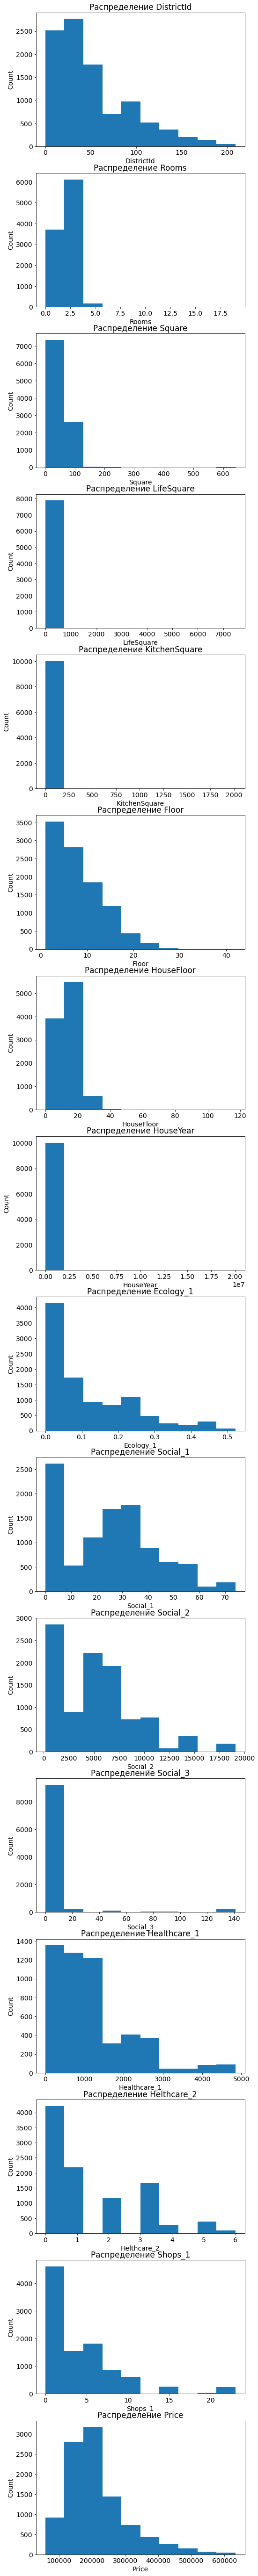

In [515]:
df_num_features = train_df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64'])
fig, axs = plt.subplots(len(df_num_features.columns), 1, figsize=(8,100))
j=0
for i in df_num_features:
    print('Сортировка признака ' + i + '\n')
    print(train_df[i].sort_values())
    axs[j].hist(train_df[i], bins=10)
    axs[j].set_title('Распределение ' + i)
    axs[j].set_xlabel(i)
    axs[j].set_ylabel('Count')
    j+=1
    print()

##### Rooms
Есть аномалия с квартирами, где количество комнат 0, заменим их на 1 комнату. Больше 5 комнат можно расценить как выброс, т.к. данные по ним не представляют статистического значения. Для лучшего обучения можно заменить на медиану.

##### Square
Аномалия по 0 значению, а так же есть длинный хвост справа после 300 м2, который, вероятно, относится к 19 комнатной квартире. Для лучшего обучения будем считать это выбросом.

#####  LifeSquare
На графике видно, что есть большой выброс, который даже больше общей площади. При обработке данных примем во внимание то, что жилая площадь не может быть больше общей площади, т.е. 300 м2

##### KitchenSquare
Аналогично LifeSquare

##### Floor
Минимальный показатель равен 1 этажу, а максимальный 42, что входит в пределы значений количества этажей в домах.

##### HouseFloor
Аномальными наблюдениями можно считать со значениями 0. Т.к. минимальное значение этажа 1. Максимальное количество этажей в доме примем за 50, т.к. выше в Московской области дома строить запрещено.

##### HouseYear
Проведена замена максимальных показателей для лучшего обучения модели

##### Social_1
Исходя из данных, похоже, что это количество кв.м. на 1 человека в квартире.

##### Social_2
По распределению выглядит как вполне нормальных показатель.

##### Social_3
Справа виден явный хвост выбросов.

##### Ecology_1
Экологический класс. Здесь аномалий не наблюдается. И среднее отклонение так же нормальное.

##### Healthcare_1
Показатель с почти 50% пропусками. Удалим этот показатель, т.к. он несет незначительную информацию и не будет включен в признаки модели.

##### Helthcare_2
Вероятно, это количество больниц поблизости. Распределение можно считать нормальным. Аномалий особых нет.

##### Shops_1
Скорее всего - это количество магазинов поблизости.

##### Price
Целевая переменная. Вероятно в условных единицах, они же доллары США. Нет повторяющихся значений.

In [516]:
#Заменим значения 20052011 и 4968 на вероятные значения этих данных
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

#### Номинативные переменные

In [517]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [518]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
117      1
205      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [519]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [520]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [521]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

_В номенативных переменных нет пропусков и данных, которые нужно изменять, но для удобства переведем буквенные значения в цифровой._

## Классы подготовки данных

In [522]:
class dataPrepare:

    def __init__(self):
        self.medians = None  # сохраним все медианы
        self.k_median_ks = None  # переменная для коэфициента медиан 
        self.current_year = datetime.now().year
        
    def fit(self, X):
        self.medians = X.median()  # Расчет медиан
    
    def transform(self, X):
        # Обработаем выбросы и нулевые значения Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 5, 'Rooms'] = self.medians['Rooms']

        # Уберем объекты площадью меньше 15 и больше 300. Урежем хвосты и околонулевые значения
        X.loc[X['Square'] > 300, 'Square'] = self.medians['Square']
        X.loc[X['Square'] < 15, 'Square'] = self.medians['Square']

        # Почистим значения KitchenSquare которые больше Square
        # Определим коэффициент отношения площади кухни к общей площади
        k_median_ks =  self.medians['KitchenSquare'] / self.medians['Square']

        # исправим площадь кухни
        X.loc[(X['KitchenSquare'] > X['Square']), 'KitchenSquare'] = k_median_ks * X['Square']

        # Уберем хвост из площадей больше 20
        X.loc[X['KitchenSquare'] > 20, 'KitchenSquare'] = self.medians['KitchenSquare']

        # Исправим пропуски LifeSquare как произведение общей площади на коэффциент жилой площади от общей
        k_median_ls = self.medians['LifeSquare'] / self.medians['Square']
        X.loc[(X['LifeSquare'] > X['Square']) | 
             (X['LifeSquare'].isna()), 'LifeSquare'] = k_median_ls * X['Square']
        
        # изменим год постройки на текущий год, если он больше, чем текущая дата
        X.loc[(train_df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year

        # обработаем нулевые этажи
        X.loc[(X['Floor'] == 0), 'Floor'] = 1
        X.loc[(X['HouseFloor'] == 0), 'HouseFloor'] = 1

        # обработаем ситуацию когда этаж больше этажности
        X.loc[(X['Floor'] > X['HouseFloor']), 'Floor'] = X['HouseFloor']
        X.loc[X['HouseFloor'] > 50, 'HouseFloor'] = self.medians['HouseFloor']

        # Из ранее определенных параметров выровняем количество человек в квартире
        X.loc[(X['Social_3'] > 10), 'Social_3'] = self.medians['Social_3']

        # Удалим признак Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        X.fillna(self.medians, inplace=True)
        
        return X


class dataDummies():
    
    def __init__(self):
        self.binary_to_numbers = None
        
    def fit(self):
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
    def transform(self, X):
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        return X

#### Разбиение на train и test

In [523]:
# Импортируем данные
train_df = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

# Создадим объекты классов и проинициализируем переменные
d_prepare = dataPrepare()
d_dummies = dataDummies()
d_prepare.fit(X_test)
d_dummies.fit()

# Подготовим данные
train_df = d_prepare.transform(train_df)
train_df = d_dummies.transform(train_df)
X_test = d_prepare.transform(X_test)
X_test = d_dummies.transform(X_test)

# Отделим целевую переменную
X = train_df.drop('Price', axis=1)
y = train_df['Price']

# Создадим тренировочные и валидацонные наборы
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

# Посмотрим на размерности и пропуски в данных. После обработки их не должно быть
print(X_train.shape, X_valid.shape, X_test.shape)
print(X_train.isna().sum().sum(), 
      X_valid.isna().sum().sum(),
      X_test.isna().sum().sum())

(6700, 18) (3300, 18) (5000, 18)
0 0 0


## Построение модели

В другом файле протестировала разные модели (Линейная регрессия, RandomForestRegressor, GradientBoostingRegressor). Лучше всего по коэффициенту детерминации подходит модель GradientBoostingRegressor.

In [524]:
scaler = RobustScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=colnames)


gbr = GradientBoostingRegressor(criterion='mse',
                                        max_depth=4,
                                        random_state=42,  
                                        n_estimators=350)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=4, n_estimators=350,
                          random_state=42)

R2 TRAIN:	0.8950192330586649
R2 TEST:	0.7472561131986539


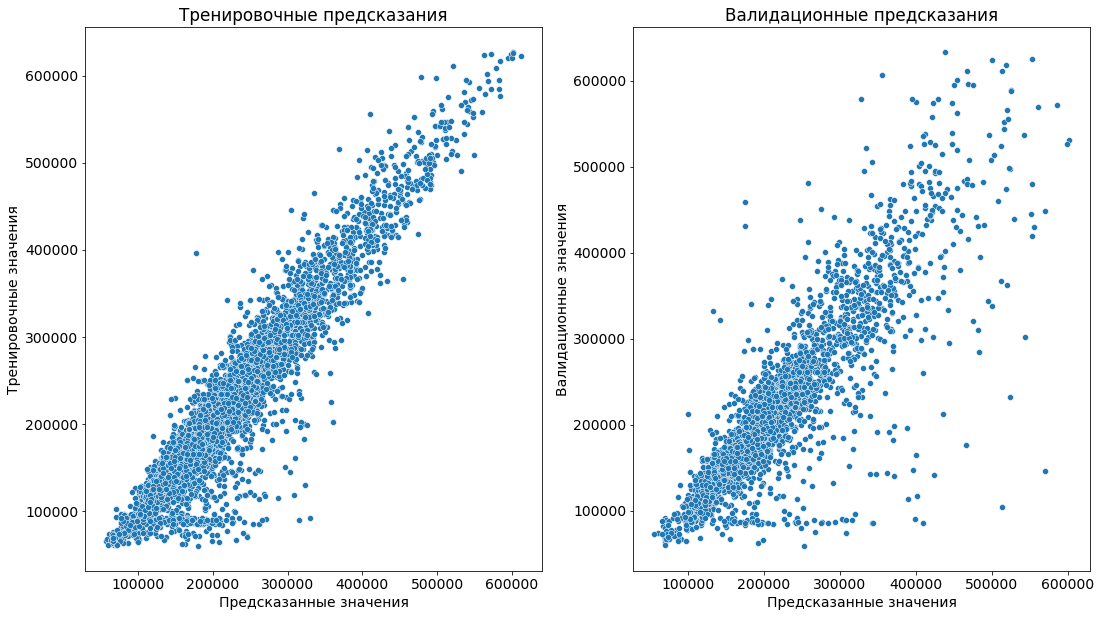

In [525]:
y_train_preds_gbr = gbr.predict(X_train)
y_valid_preds_gbr = gbr.predict(X_valid)

r2_metrics(y_train, y_valid, y_train_preds_gbr, y_valid_preds_gbr)

               importance
feature                  
Square           0.420748
Social_1         0.093687
Social_2         0.086590
DistrictId       0.075148
Rooms            0.060121
Social_3         0.050321
Ecology_1        0.049444
HouseYear        0.041549
KitchenSquare    0.024935
Shops_1          0.024019
LifeSquare       0.019232
HouseFloor       0.018698
Id               0.013485
Floor            0.011397
Helthcare_2      0.008658
Shops_2          0.001485
Ecology_3        0.000393
Ecology_2        0.000089


<AxesSubplot:ylabel='feature'>

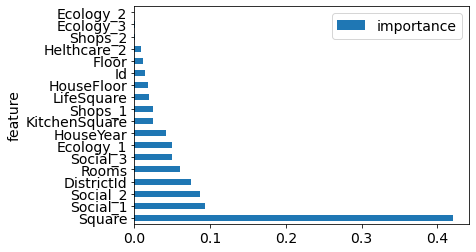

In [526]:
imp = pd.DataFrame({'feature': X_train_scaled.columns,'importance': gbr.feature_importances_})
imp = imp.sort_values('importance', ascending=False).set_index('feature')

print(imp)

imp.plot.barh()

Вывод по **Gradient Boosting Regressor**:  

На основе наблюдений хороших показателей получилось достигнуть с параметрами:

* criterion='mse',
* max_depth=4,
* random_state=42,
* n_estimators=350

**Значения R2 вышли:**

  **R2 TRAIN** : 0.8950192330586649  
  **R2 VALID** : 0.7472561131986539  
  
  При этом наблюдается некоторое переобучение модели, вероятно, на признаке Square, т.к. его важность имеет значение в районе 0,4

## Прогнозирование на тестовом датасете

In [527]:
# Снова для чистоты импортируем данные
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

# Создадим объекты классов и проинициализируем переменные
d_prepare = dataPrepare()
d_dummies = dataDummies()
d_prepare.fit(X_test)
d_dummies.fit()

# Подготовим данные
X_train = d_prepare.transform(X_train)
X_train = d_dummies.transform(X_train)
X_test = d_prepare.transform(X_test)
X_test = d_dummies.transform(X_test)

# Отделим целевую переменную
X = X_train.drop('Price', axis=1)
y = X_train['Price']

# Посмотрим на размерности и пропуски в данных. После обработки их не должно быть
print(X.shape, X_test.shape)
print(X.isna().sum().sum(), 
      X_test.isna().sum().sum())

(10000, 18) (5000, 18)
0 0


In [528]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=4,
                                        random_state=42,  
                                        n_estimators=350)

final_model.fit(X, y)

y_train_preds_gbr = final_model.predict(X)
y_test_preds_gbr = final_model.predict(X_test)

In [529]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [530]:
submit['Price'] = y_test_preds_gbr
submit.head()

,Id,Price
0,4567,162000.583289
1,5925,118651.437030
2,960,148785.321099
3,3848,111386.833649
4,746,202753.599012


#### Запись на csv

In [532]:
submit.to_csv('DRozina_prescription.csv', index=False)